# Declare Function

## Import function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import psycopg2
import pandas.io.sql as psql
from tqdm.autonotebook import tqdm
import pickle
import math
import scorecardpy as sc
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta

#### FEATURE ENGINEERING ####
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler # Standardize data (0 mean, 1 stdev)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV

#### MODEL TRAINING ####
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold

#### MODEL ALGORITHMS ####
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluate
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import statsmodels.api as sm
from scipy.stats import ks_2samp
import shap

# Save Model
#from sklearn.externals import joblib
import joblib

d:\Users\NiTeerapat\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
d:\Users\NiTeerapat\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
d:\Users\NiTeerapat\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Build function

In [2]:
def rename_col(df):
    invalid_col = [ col for col in df if(('[' in col) or (']' in col) or ('&' in col))]
    for i in invalid_col:
        df.rename(columns={ i : i.replace( ("[") ,"_") }, inplace=True)
        df.rename(columns={ i : i.replace( ("]") ,"_") }, inplace=True)
        df.rename(columns={ i : i.replace( ("&") ,"and") }, inplace=True)
        df.rename(columns={ i : i.replace( ("<") ,"less") }, inplace=True)
    #print("Change %d Invalid Columns's Name Base: %s" % (len(invalid_col),base))
    return df

In [3]:
def replace_nan(df):
    # Replace NaN Value
    for col in df.select_dtypes(exclude=['int64','float64']).columns.values:
        # if all values in dataset is null, then convert to int (0)
        if len(df) == len(df[df[col].isnull()]):
            df[col] = 0
        else:
            df[col].fillna('UNKNOWN',inplace=True)            

    for col in df.select_dtypes(['int64','float64']).columns.values:
        df[col].fillna(0,inplace=True)
    return df

In [4]:
def clean_less_than_zero(df):
    # Replace less than 0 value
    for col in df.select_dtypes(['int64','float64']).columns.values:
        df.loc[df[col] <= 0,col] = 0
    return df

In [5]:
def take_log(df):
    # Replace less than 0 value
    for col in df[[column for column in df if column.find('_flag') == -1]].select_dtypes(['int64','float64']).columns.values:
        df.loc[:,col] = df.loc[:,col].apply(lambda x : math.log(x+0.05))
    return df

In [6]:
def replace_zero_with_mean(df):
    for col in df[[column for column in df if column.find('_flag') == -1]].select_dtypes(['int64','float64']).columns.values:
        mean = df[df[col] > 0].mean()
        df.loc[(df[col] <= 0) | (df[col].isna()),col] = mean
    return df

In [7]:
def select_column(df):
    column_list = []
    df_for_column_list = df[[column for column in df if column.find('overall') == -1]]
    df_for_column_list = df[[column for column in df if column.find('relevance') == -1]]
    df_for_column_list = df[[column for column in df if column.find('fine_dining') == -1]]
    df_for_column_list = df[[column for column in df if column.find('overseas') == -1]]
    df_for_column_list = df[[column for column in df if column.find('home_lux_score') == -1]]
    df_for_column_list = df[[column for column in df if column.find('food_lux_score') == -1]]
    df_for_column_list = df[[column for column in df if column.find('fashion_lux_score') == -1]]
    df_for_column_list = df[[column for column in df if column.find('beauty_lux_score') == -1]]
    for col in df_for_column_list[[column for column in df_for_column_list if column.find('_flag') != -1]].columns.values:
        column_list.append(col)
    for col in df_for_column_list[[column for column in df_for_column_list if column.find('customer_id') != -1]].columns.values:
        column_list.append(col)
    for col in df_for_column_list[[column for column in df_for_column_list if column.find('real_estate') != -1]].columns.values:
        column_list.append(col)
    for col in df_for_column_list[[column for column in df_for_column_list if column.find('investment') != -1]].columns.values:
        column_list.append(col)
    for col in df_for_column_list[[column for column in df_for_column_list if column.find('europe_car_ownership') != -1]].columns.values:
        column_list.append(col)
    for col in df_for_column_list[[column for column in df_for_column_list if column.find('_score') != -1]].columns.values:
        column_list.append(col)
    column_list = pd.DataFrame(column_list)
    return column_list[column_list[0]].unique()

In [8]:
def f_high_variance(x,variance):
    var_threshold = VarianceThreshold(threshold=(variance*(1-variance))).fit(x)
    out = pd.DataFrame(var_threshold.fit_transform(x), 
                        columns=x.columns.values[var_threshold.get_support()])
    return out

In [9]:
def save_model(fit,name): 
    filename = 'Model_algo_%s_score.sav' % (name)
    joblib.dump(fit,filename)
    return;

In [10]:
def save_model_dict(fit,name,seg): 
    filename = 'Model_algo_%s_seg_%s_Final_2_segments.sav' % (name,seg)
    joblib.dump(fit,filename)
    return;

In [11]:
def get_num_correct(y, y_pred):#, t=0.5):
    y_correct = np.array([0.0 if p < len(y_pred) else 1.0 for p in y_pred])
    return sum([1.0 for p, p_pred in zip(y, y_correct) if p == p_pred])

def get_count_most_freq_outcome(y):
    num_0 = 0
    num_1 = 0
    for p in y:
        if p == 1.0:
            num_1 += 1
        else:
            num_0 += 1
    return float(max(num_0, num_1))

def count_adjusted_rsquare(y, y_pred):#, t=0.5):
    correct = get_num_correct(y, y_pred)
    total = float(len(y))
    n = get_count_most_freq_outcome(y)
    return (correct - n) / (total - n)

# Data Pre-processing

## Import data

In [12]:
# #Connecting to SQL
# driver = 'SQL Server'
# server = '10.0.21.97'
# database = 'VPM_Backup'
# # username = 'VPM_Supat'
# # password = 'Supat_VPM'
# cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')

In [13]:
# # Extract data from SQL
# sql= ("""SELECT A.*
#             FROM VPM_DEV..B_AFFLUENT_MODEL_DF_FIT A
#             INNER JOIN VPM_DEV..B_AFFLUENT_MODEL_TRAIN_CUST B ON A.CUSTOMER_ID = B.CUSTOMER_ID
#             """)
# df = pd.read_sql_query(sql,cnxn)
# df.to_pickle('df_Final.pickle')

In [14]:
# # Extract data from SQL
# sql_score= ("""SELECT CUSTOMER_ID,FINAL_AFFLUENT_SCORE
#             FROM VPM_DEV..B_AFFLUENT_SCORE_ACTIVE_1YR_SCORE_COMPARE_1220 
#             """)
# df_score_previous = pd.read_sql_query(sql_score,cnxn)
# df_score_previous.to_pickle('df_score_previous.pickle')
# #df_score_previous = pd.read_pickle('df_score_previous.pickle')

In [15]:
# # Extract data from SQL
# sql_score= ("""SELECT CUSTOMER_ID,FINAL_AFFLUENT_SCORE
#            FROM VPM_DEV..B_AFFLUENT_SCORE_ACTIVE_1YR_20201204
#            """)
# df_score_1120 = pd.read_sql_query(sql_score,cnxn)
# df_score_1120.to_pickle('df_score_1120.pickle')
df_score_1120 = pd.read_pickle('df_score_1120.pickle')

In [16]:
connection = psycopg2.connect(user="teerapat",
                                password="Password112020",
                                host="the1-rds-aurora-1-instance-1.cijy1qoqmhdq.ap-southeast-1.rds.amazonaws.com",
                                port="5432",
                                database="postgres")

sql = ("""SELECT A.* FROM VPM_DATA.B_AFFLUENT_MODEL_DF_FIT A
       INNER JOIN VPM_DATA.B_AFFLUENT_MODEL_TRAIN_CUST B ON A.CUSTOMER_ID = B.CUSTOMER_ID""")

cursor = connection.cursor()
df = psql.read_sql(sql, connection)
cursor.close()
df.to_pickle('df_Final.pickle')

In [17]:
# aff = pd.read_pickle('df_Final.pickle')

In [18]:
# aff[affluent_flag == 1].nunique('customer_id')

In [19]:
# last_month_date = datetime.today()+relativedelta(months=-1)
# connection = psycopg2.connect(user="teerapat",
#                                 password="Password112020",
#                                 host="the1-rds-aurora-1-instance-1.cijy1qoqmhdq.ap-southeast-1.rds.amazonaws.com",
#                                 port="5432",
#                                 database="postgres")

# sql = ("SELECT * FROM VPM_DATA.B_AFFLUENT_SCORE_ACTIVE_1YR_SCORE_COMPARE_%s" %(today.strftime('%m')+today.strftime('%y')))

# cursor = connection.cursor()
# df_score_previous = psql.read_sql(sql, connection)
# cursor.close()
# df_score_previous.to_pickle('df_score_previous.pickle')

In [20]:
#df = pd.read_pickle('df_Final.pickle')

In [27]:
df.loc[df.affluent_flag == 1,'customer_id'].nunique()

245830

In [28]:
df.columns = df.columns.str.lower()
df_score_1120.columns = df_score_1120.columns.str.lower()

In [29]:
df=df[df['commercial_flag']==0].reset_index(drop=True)
df.drop(['commercial_flag','rn'],axis=1,inplace=True)

In [30]:
df.columns.values

array(['customer_id', 'gcs_total_investment',
       'gcs_total_insurance_premium', 'cg_total_real_estate',
       'gcs_europe_car_ownership_flag', 'cg_golf_flag',
       'beauty_upper_mass_sales_ratio', 'beauty_acc_lux_sales_ratio',
       'beauty_lux_sales_ratio', 'beauty_lux_score',
       'beauty_acc_lux_score', 'beauty_upper_mass_score',
       'beauty_makeup_lux_score', 'beauty_makeup_acc_lux_score',
       'beauty_makeup_upper_mass_score', 'beauty_skincare_lux_score',
       'beauty_skincare_acc_lux_score',
       'beauty_skincare_upper_mass_score', 'beauty_fragrance_lux_score',
       'beauty_fragrance_acc_lux_score',
       'beauty_fragrance_upper_mass_score',
       'beauty_makeup_upper_mass_sales_ratio',
       'beauty_makeup_acc_lux_sales_ratio',
       'beauty_makeup_lux_sales_ratio',
       'beauty_skincare_upper_mass_sales_ratio',
       'beauty_skincare_acc_lux_sales_ratio',
       'beauty_skincare_lux_sales_ratio',
       'beauty_fragrance_upper_mass_sales_ratio',
    

In [31]:
df_cleaned = {}
ref_used_col = {}
df = replace_nan(df)
df = clean_less_than_zero(df)
columns_dummy = df.iloc[:0,1:-2].select_dtypes(exclude=['int64','float64']).columns.values
columns_predict = ['gcs_flag','affluent_flag']
#Convert Text Features to Binary Columns
df_dummy = pd.get_dummies(df[columns_dummy])
for col in columns_dummy:
    df_dummy.drop(col+'_UNKNOWN',axis=1,inplace=True)
predicted_val = df[columns_predict]

#Drop old Columns
df.drop(columns_dummy,axis=1,inplace=True)
df.drop(columns_predict,axis=1,inplace=True)

#Merge Dummy Data and Predicted Values (Y) for modeling
df_cleaned = rename_col(pd.concat([df,df_dummy,predicted_val], axis=1))

In [32]:
ref_used_col = df_cleaned.columns.values

In [33]:
with open('ref_used_col.pickle', 'wb') as f:
    pickle.dump(ref_used_col,f)

In [34]:
cust_in_cg_not_gcs = list(df_cleaned.loc[df_cleaned['gcs_flag']==0,'customer_id'])

df_used = {}
df_used['GCS'] = df_cleaned.loc[df_cleaned['gcs_flag']==1,:].copy().drop('gcs_flag',axis=1).reset_index(drop=True)
df_used['CG'] = df_cleaned.copy().drop('gcs_flag',axis=1).reset_index(drop=True)

df_used['GCS'] = take_log(df_used['GCS']).reset_index(drop=True)
df_used['CG'] = take_log(df_used['CG']).reset_index(drop=True)

In [35]:
features_used = {}
features_used['GCS'] = df_used['GCS'].columns.values
features_used['CG'] = [col for col in df_used['CG'].columns.values if col.find('hotel_') == -1
                                                                    and col.find('inter_') == -1
                                                                    and col.find('travel_') == -1
                                                                    and col.find('dining_') == -1
                                                                    and col.find('hospital_') == -1]

In [36]:
for seg in features_used.keys():
    print('%i customers in inference group = %s' % (len(df_used[seg]),seg))

222312 customers in inference group = GCS
1375818 customers in inference group = CG


# Modelling

## Create model

In [37]:
# def LR_RFE_Tuning(x,y):
#     kfold = KFold(n_splits=3)    
#     print('===================================================')
#     print('== GridSearchCV for Logistic Regression with RFE ==')
    
#     ## Parameters List
#     C_list = np.array([1,0.1,0.01])
    
    
#     logreg = LogisticRegression(solver='lbfgs',penalty='l2',max_iter=500,class_weight='balanced')
    
#     rfecv = RFECV(estimator=logreg, 
#                   step=1, 
#                   cv=5, 
#                   scoring = 'recall')
    
#     ## Fit Algorithm with Parameters List
#     ## Step2. Create Pipeline
#     pipe = Pipeline([('standardize', StandardScaler()),
#                       ('feature_selection', rfecv),
#                      ('regression', logreg)
#                     ])

#     param_grids = [{'regression__C':C_list}]

#     grid = GridSearchCV(estimator = pipe,
#                         param_grid = param_grids,
#                         cv=kfold,
#                         scoring = 'recall',
#                         return_train_score = True)
    
    
    

#     model_fit = grid.fit(x,y)
    
    
#     ## Tuning Result
#     means_train = model_fit.cv_results_['mean_train_score']
#     stds_train = model_fit.cv_results_['std_train_score']
#     means = model_fit.cv_results_['mean_test_score']
#     stds = model_fit.cv_results_['std_test_score']
#     params = model_fit.cv_results_['params']
#     print('Best AUC = %.4f, C = %s\n' % (model_fit.best_score_, model_fit.best_params_))
#     for mean_train,std_train,mean,stdev,param in zip(means_train,stds_train,means,stds,params):
#         print('with params: %s >> Train %.4f, Test %.4f (std %.4f)' 
#               % (param,mean_train,mean,stdev))

#     LR_RFE_USED = pipe.set_params(**model_fit.best_params_)
    
#     return model_fit.best_score_, LR_RFE_USED

In [38]:
def LR_Tuning(x,y):
    kfold = KFold(n_splits=3)    
    print('==========================================')
    print('== GridSearchCV for Logistic Regression ==')
    
    ## Parameters List
    C_list = np.array([1,0.1,0.01])
    
    
    logreg = LogisticRegression(solver='lbfgs',penalty='l2',max_iter=500,class_weight='balanced')
    
    
    ## Fit Algorithm with Parameters List
    ## Step2. Create Pipeline
    pipe = Pipeline([('standardize', StandardScaler()),
                     ('regression', logreg)
                    ])

    param_grids = [{'regression__C':C_list}]

    grid = GridSearchCV(estimator = pipe,
                        param_grid = param_grids,
                        cv=kfold,
                        scoring = 'recall',
                        return_train_score = True)
    
    
    

    model_fit = grid.fit(x,y)
    
    
    ## Tuning Result
    means_train = model_fit.cv_results_['mean_train_score']
    stds_train = model_fit.cv_results_['std_train_score']
    means = model_fit.cv_results_['mean_test_score']
    stds = model_fit.cv_results_['std_test_score']
    params = model_fit.cv_results_['params']
    print('Best AUC = %.4f, C = %s\n' % (model_fit.best_score_, model_fit.best_params_))
    for mean_train,std_train,mean,stdev,param in zip(means_train,stds_train,means,stds,params):
        print('with params: %s >> Train %.4f, Test %.4f (std %.4f)' 
              % (param,mean_train,mean,stdev))

    LR_USED = pipe.set_params(**model_fit.best_params_)
    
    return model_fit.best_score_, LR_USED

In [39]:
# def LGB_Tuning(x,y):
#     print('================================')
#     print('== GridSearchCV for Light GBM ==')
#     kfold = KFold(n_splits=3)
#     max_depth = np.array([4,5,6])
#     min_split_gain = np.array([0.0,0.1,0.3])
#     subsample = np.array([0.8])
#     colsample_bytree = np.array([0.8])
#     default_tree = np.array([31])
#     n_tree = np.array([31,80])
#     reg_lambda = np.array([1])
#     learning_rate = np.array([0.1])
#     min_child_weight = np.array([30,50])

#     class param_grid:
#         A = dict(n_estimators = default_tree, min_child_weight = min_child_weight, 
#                  max_depth = max_depth, reg_lambda = reg_lambda)
#         B = dict(n_estimators = default_tree, min_split_gain = min_split_gain)
#         C = dict(n_estimators = default_tree, subsample = subsample, colsample_bytree = colsample_bytree)
#         D = dict(n_estimators = n_tree, learning_rate = learning_rate)
        
#     #Loop to Fit Algorithms with Multiple Parameter Type
#     TUNED_DICT = {}
#     #for i in ['A','B','C','D']:
#     for i in ['A','C','D']:
#         print('\nTuning Parameters SET = %s' % i)        
#         if i == 'A':
#             grid = GridSearchCV(estimator = lgb.LGBMClassifier(class_weight = 'balanced'), 
#                                 param_grid = param_grid.__dict__[i], 
#                                 scoring = 'recall',
#                                 cv=kfold,
#                                 return_train_score = True)
#         else:
#             grid = GridSearchCV(estimator = lgb.LGBMClassifier(class_weight = 'balanced').set_params(**TUNED_DICT), 
#                                 param_grid = param_grid.__dict__[i], 
#                                 scoring = 'recall',
#                                 cv=kfold,
#                                 return_train_score = True)
#         model_fit = grid.fit(x,y)
#         means_train = model_fit.cv_results_['mean_train_score']
#         stds_train = model_fit.cv_results_['std_train_score']
#         means = model_fit.cv_results_['mean_test_score']
#         stds = model_fit.cv_results_['std_test_score']
#         params = model_fit.cv_results_['params']
#         print('Best AUC = %.4f, Params = %s' % (model_fit.best_score_, model_fit.best_params_))

#         TUNED_DICT.update(model_fit.best_params_)
#         print('Updated Parameters Dict = %s' % TUNED_DICT)

#         LGB_USED = lgb.LGBMClassifier(class_weight = 'balanced').set_params(**TUNED_DICT)   
        
#     return model_fit.best_score_, LGB_USED

In [40]:
# def XGB_Tuning(x,y):
#     print('==========================')
#     print('== GridSearchCV for XGB ==')
#     kfold = KFold(n_splits=3)
#     min_child_sample = np.array([int(len(x)*0.005),int(len(x)*0.01),int(len(x)*0.03),int(len(x)*0.05)])
#     max_depth = np.array([4,5])
#     gamma = np.array([0.0,0.1,0.2,0.4])
#     subsample = np.array([0.8,1.0])
#     colsample_bytree = np.array([0.8,1.0])
#     default_tree = np.array([20])
#     n_tree = np.array([100])
#     learning_rate = np.array([0.1,0.05,0.01])
#     reg_lambda = np.array([1])
    
#     class param_grid:
#         A = dict(n_estimators = default_tree, min_child_sample = min_child_sample, 
#                  max_depth = max_depth, nthread=np.array([-1]) #np.array([4]) #-1
#                  , reg_lambda = reg_lambda)
#         B = dict(n_estimators = default_tree, gamma = gamma, nthread=np.array([4]))
#         C = dict(n_estimators = default_tree, subsample = subsample, colsample_bytree = colsample_bytree, nthread=np.array([4]))
#         D = dict(n_estimators = n_tree, learning_rate = learning_rate, nthread=np.array([4]))

#     #LOOP TO FIT ALGORITHMS WITH MULTIPLE PARAMETERS
#     TUNED_DICT = {}
#     for i in ['A','B','C','D']:
#         print('\nTuning Parameters SET = %s' % i)        
#         if i == 'A':
#             grid = GridSearchCV(estimator = XGBClassifier(class_weight = 'balanced'), 
#                                 param_grid = param_grid.__dict__[i], 
#                                 cv=kfold,
#                                 scoring = 'recall',
#                                 return_train_score = True)
#         else:
#             grid = GridSearchCV(estimator = XGBClassifier(class_weight = 'balanced').set_params(**TUNED_DICT), 
#                                 param_grid = param_grid.__dict__[i], 
#                                 cv=kfold,
#                                 scoring = 'recall',
#                                 return_train_score = True)
#         model_fit = grid.fit(x,y)
#         means_train = model_fit.cv_results_['mean_train_score']
#         stds_train = model_fit.cv_results_['std_train_score']
#         means = model_fit.cv_results_['mean_test_score']
#         stds = model_fit.cv_results_['std_test_score']
#         params = model_fit.cv_results_['params']
#         print('Best AUC = %.4f, Params = %s' % (model_fit.best_score_, model_fit.best_params_))
        
#         TUNED_DICT.update(model_fit.best_params_)
#         print('Updated Parameters Dict = %s' % TUNED_DICT)
        
#         XGB_USED = XGBClassifier(class_weight = 'balanced').set_params(**TUNED_DICT)              
#     return model_fit.best_score_, XGB_USED

In [41]:
# def RF_Tuning(x,y):
#     print('==========================')
#     print('== GridSearchCV for RF ==')
#     kfold = KFold(n_splits=3)
#     min_samples_split = np.array([int(len(x)*0.005),int(len(x)*0.01),int(len(x)*0.03),int(len(x)*0.05)])
#     min_child_weight = int(len(x)*0.03),int(len(x)*0.05),int(len(x)*0.07)
#     max_depth = np.array([4,5,6,7])
#     gamma = np.array([0.0,0.1,0.2,0.4])
#     subsample = np.array([0.8,1.0])
#     colsample_bytree = np.array([0.8,1.0])
#     default_tree = np.array([20])
#     n_tree = np.array([100])
#     learning_rate = np.array([0.1,0.05,0.01])
#     reg_lambda = np.array([1])
    
#     class param_grid:
#         A = dict(n_estimators = default_tree,
#                  min_samples_split = min_samples_split,
#                  max_depth = max_depth#, nthread=np.array([4]) #-1
#                  #, reg_lambda = reg_lambda
#                 )
#         B = dict(n_estimators = default_tree, #gamma = gamma, nthread=np.array([4])
#                 )
#         C = dict(n_estimators = default_tree, #subsample = subsample,
#                  #colsample_bytree = colsample_bytree, nthread=np.array([4])
#                 )
#         D = dict(n_estimators = n_tree, #learning_rate = learning_rate, nthread=np.array([4])
#                 )

#     #LOOP TO FIT ALGORITHMS WITH MULTIPLE PARAMETERS
#     TUNED_DICT = {}
#     for i in ['A','B','C','D']:
#         print('\nTuning Parameters SET = %s' % i)        
#         if i == 'A':
#             grid = GridSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced'), 
#                                 param_grid = param_grid.__dict__[i], 
#                                 cv=kfold,
#                                 scoring = 'recall',
#                                 return_train_score = True)
#         else:
#             grid = GridSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced').set_params(**TUNED_DICT), 
#                                 param_grid = param_grid.__dict__[i], 
#                                 cv=kfold,
#                                 scoring = 'recall',
#                                 return_train_score = True)
#         model_fit = grid.fit(x,y)
#         means_train = model_fit.cv_results_['mean_train_score']
#         stds_train = model_fit.cv_results_['std_train_score']
#         means = model_fit.cv_results_['mean_test_score']
#         stds = model_fit.cv_results_['std_test_score']
#         params = model_fit.cv_results_['params']
#         print('Best AUC = %.4f, Params = %s' % (model_fit.best_score_, model_fit.best_params_))
        
#         TUNED_DICT.update(model_fit.best_params_)
#         print('Updated Parameters Dict = %s' % TUNED_DICT)
        
#         RF_USED = RandomForestClassifier(class_weight = 'balanced').set_params(**TUNED_DICT)              
#     return model_fit.best_score_, RF_USED

In [42]:
def model_scoring_dict(df,seg,y):
    train, test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42, stratify=df.iloc[:,-1])
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    print('Train %i records, Y = %i' % (len(train),len(train[train[y] > 0])))
    print('Test %i records, Y = %i' % (len(test),len(test[test[y] > 0])))
    
    x_train = f_high_variance(train.iloc[:,1:-1],.999)
    train_column = x_train.columns.values    
    x_test = test.loc[:,train_column]
        
    y_train = train[y]
    y_test = test[y]
       
    time_start = time.time()
    LR_score, LR_USED = LR_Tuning(x_train,y_train)
    time_end = time.time()
#     time_start = time.time()
#     LGB_score, LGB_USED = LGB_Tuning(x_train,y_train)
#     time_end = time.time()
#     print("LGB tuning time spent = %f" %(time_end - time_start))
#     time_start = time.time()
#     XGB_score, XGB_USED = XGB_Tuning(x_train,y_train)
#     time_end = time.time()
#     print("XGB tuning time spent = %f" %(time_end - time_start))
#     time_start = time.time()
#     RF_score, RF_USED = RF_Tuning(x_train,y_train)
#     time_end = time.time()
#     print("RF tuning time spent = %f" %(time_end - time_start))
    
    models = []
    models.append(('LR', LR_USED))
#     models.append(('LGB', LGB_USED))
#     models.append(('RF', RF_USED))
#     models.append(('XGB', XGB_USED))

    result_train = []
    result_test = []
    model_fpr = {}
    model_tpr = {}
    for name, model in models:
        time_start = time.time()
        fit_train = model.fit(x_train, y_train)
        y_prob_train = fit_train.predict_proba(x_train)
        y_prob_test = fit_train.predict_proba(x_test.loc[:,x_train.columns.values])
        
        y_pred_train = fit_train.predict(x_train)
        y_pred_test = fit_train.predict(x_test.loc[:,x_train.columns.values])
        
        
        

        auc_train = roc_auc_score(y_train, pd.DataFrame(y_prob_train[:,1]))
        auc_test = roc_auc_score(y_test, pd.DataFrame(y_prob_test[:,1]))
        
        # calculate roc curves --> build in train data according to P'Wan
        base_prob_train = [0 for _ in range(len(y_train))]
        base_fpr, base_tpr, base_thresholds = roc_curve(y_train, base_prob_train)
        model_fpr[name], model_tpr[name], model_thresholds = roc_curve(y_train, y_prob_train[:,1])
        
        
        precision_train = precision_score(y_train, y_pred_train)
        precision_test = precision_score(y_test, y_pred_test)
        
        recall_train = recall_score(y_train, y_pred_train)
        recall_test = recall_score(y_test, y_pred_test)

        f1_score_train = fbeta_score(y_train, y_pred_train,1)
        f1_score_test = fbeta_score(y_test, y_pred_test,1)

        f2_score_train = fbeta_score(y_train,y_pred_train,2)
        f2_score_test = fbeta_score(y_test, y_pred_test,2)
        
          
        print('TRAIN Algo = %s, AUC = %.4f, Precision = %.4f, Recall = %.4f, F1 Score = %.4f, F2 Score = %.4f' % (name,auc_train,precision_train,recall_train,f1_score_train,f2_score_train))
        print('TEST Algo = %s, AUC = %.4f, Precision = %.4f, Recall = %.4f, F1 Score = %.4f, F2 Score = %.4f' % (name,auc_test,precision_test,recall_test,f1_score_test,f2_score_test))

        if name in ['LGB','RF']:
            explainer = shap.TreeExplainer(fit_train)
            feature_for_shap = sorted(zip(map(lambda x: round(x,4),fit_train.feature_importances_),train_column),reverse=True)
            shap_values = explainer.shap_values(x_test)
            print(feature_for_shap)
            shap.summary_plot(shap_values[1], x_test)
            plt.show()
        elif name in ['XGB']:
            explainer = shap.TreeExplainer(fit_train)
            shap_values = explainer.shap_values(x_test)
            shap.summary_plot(shap_values, x_test)
            plt.show()
        
        precision, recall, _ = precision_recall_curve(y_train, y_prob_train[:,1])
        auc_score = auc(recall,precision)
        pr_curve = plot_precision_recall_curve(model,x_train,y_train)
        pr_curve.ax_.set_title('2-class Precision-Recall Curve for %s : '
                   'AUC =%0.4f' %(name,auc_score),fontsize = 15)
        plt.xlabel('Recall',size = 15)
        plt.ylabel('Precision',size = 15)
        plt.xticks(size = 15)
        plt.yticks(size = 15)
        plt.legend(prop={"size":15})
        plt.show()
        
        precision, recall, _ = precision_recall_curve(y_test, y_prob_test[:,1])
        auc_score = auc(recall,precision)
        pr_curve = plot_precision_recall_curve(model,x_test,y_test)
        pr_curve.ax_.set_title('2-class Precision-Recall Curve for %s : '
                   'AUC =%0.4f' %(name,auc_score),fontsize = 15)
        plt.xlabel('Recall',size = 15)
        plt.ylabel('Precision',size = 15)
        plt.xticks(size = 15)
        plt.yticks(size = 15)
        plt.legend(prop={"size":15})
        plt.show()
        
        save_model_dict(model,name,seg)
        
        time_end = time.time()
        print("%s prediction time spent = %f" %(name,time_end - time_start))
    
    plt.figure(figsize=(10,10))
    # axis labels
    plt.title('ROC - AUC',size = 20)
    plt.xlabel('False Positive Rate',size = 20)
    plt.ylabel('True Positive Rate',size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    # plot the roc curve for the model
    plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline', color = 'k')
    for name in model_fpr.keys():
        plt.plot(model_fpr[name], model_tpr[name], linestyle='-', label=name)
    # show the legend
    plt.legend(prop={"size":20})
    # show the plot
    plt.show()

    return train_column, result_train, result_test

## Implement model


== Dataset GCS ==
Train 155618 records, Y = 43710
Test 66694 records, Y = 18733
== GridSearchCV for Logistic Regression ==
Best AUC = 0.5713, C = {'regression__C': 0.01}

with params: {'regression__C': 1.0} >> Train 0.5723, Test 0.5709 (std 0.0027)
with params: {'regression__C': 0.1} >> Train 0.5722, Test 0.5709 (std 0.0028)
with params: {'regression__C': 0.01} >> Train 0.5725, Test 0.5713 (std 0.0024)


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error


TRAIN Algo = LR, AUC = 0.6597, Precision = 0.3938, Recall = 0.5718, F1 Score = 0.4664, F2 Score = 0.5244
TEST Algo = LR, AUC = 0.6585, Precision = 0.3935, Recall = 0.5640, F1 Score = 0.4636, F2 Score = 0.5190


Creating legend with loc="best" can be slow with large amounts of data.


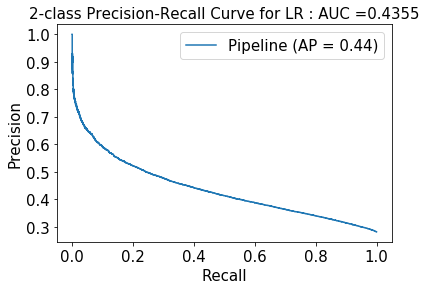

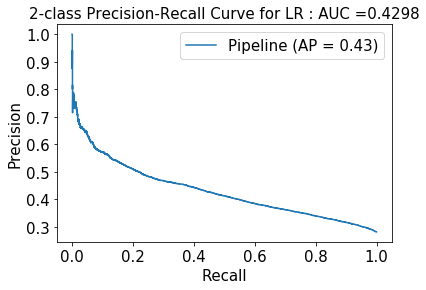

LR prediction time spent = 3.034918


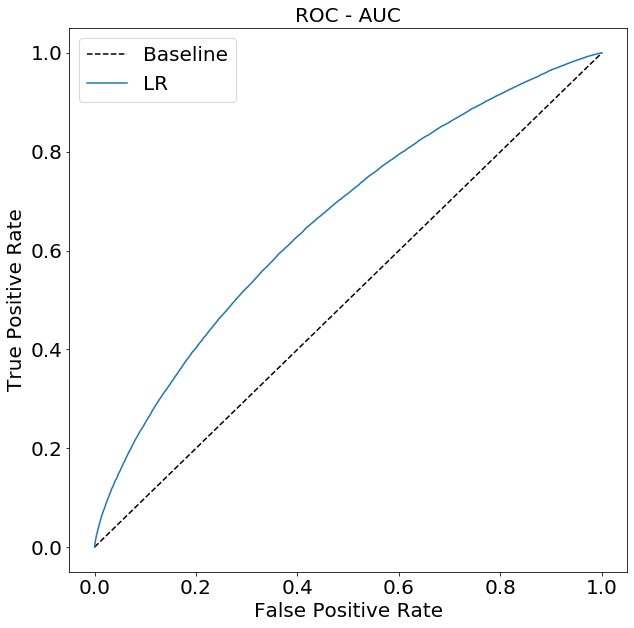


== Dataset CG ==
Train 963072 records, Y = 166712
Test 412746 records, Y = 71448
== GridSearchCV for Logistic Regression ==
Best AUC = 0.6128, C = {'regression__C': 0.1}

with params: {'regression__C': 1.0} >> Train 0.6133, Test 0.6128 (std 0.0009)
with params: {'regression__C': 0.1} >> Train 0.6133, Test 0.6128 (std 0.0009)
with params: {'regression__C': 0.01} >> Train 0.6133, Test 0.6127 (std 0.0008)


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error


TRAIN Algo = LR, AUC = 0.6817, Precision = 0.2682, Recall = 0.6133, F1 Score = 0.3732, F2 Score = 0.4878
TEST Algo = LR, AUC = 0.6813, Precision = 0.2679, Recall = 0.6128, F1 Score = 0.3728, F2 Score = 0.4873


Creating legend with loc="best" can be slow with large amounts of data.


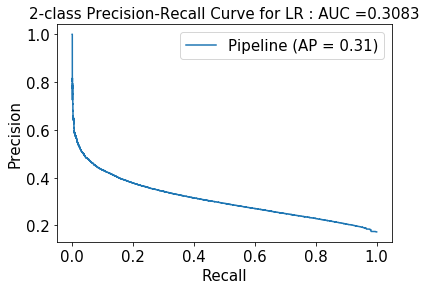

Creating legend with loc="best" can be slow with large amounts of data.


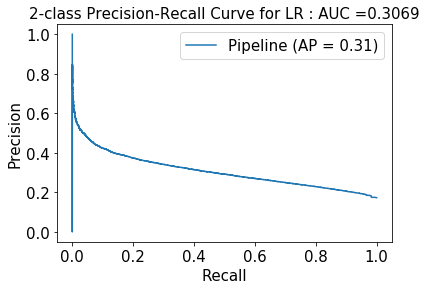

LR prediction time spent = 13.295665


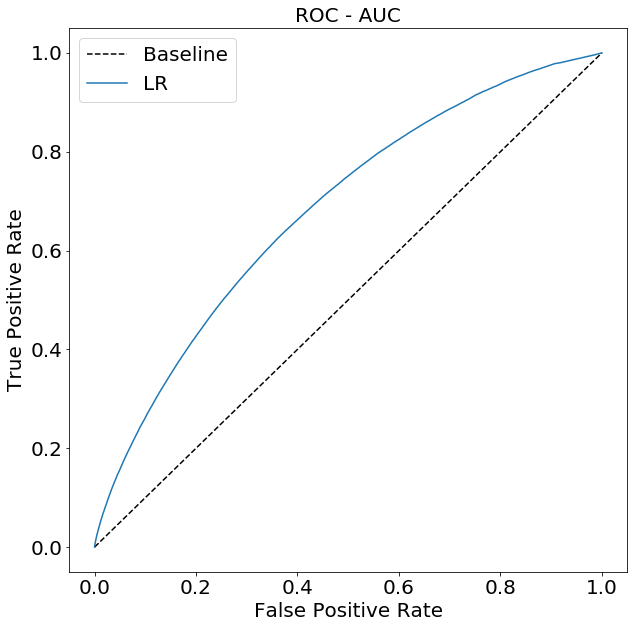

In [43]:
###50K SPEND TIME : 37MINS (WITH RFE)
###ALL SPEND TIME (4 MODEL) : 1HR 12 MINS
train_col = {}
result_train = {}
result_test = {}
# Calcualte wealth score by 3 groups of known features
for seg in features_used.keys():
    print('\n== Dataset %s ==' % seg)
    train_col[seg], result_train[seg], result_test[seg] = model_scoring_dict(df_used[seg][features_used[seg]],seg,'affluent_flag')

In [44]:
# ## Backup result ##
# with open('result_train.pickle', 'wb') as f:
#     pickle.dump(result_train,f)
# with open('result_test.pickle', 'wb') as f:
#     pickle.dump(result_test,f)
with open('train_col.pickle', 'wb') as f:
     pickle.dump(train_col,f)

## Feature importance

In [45]:
# Load Model from Backup
# from sklearn.externals import joblib
train_col = pd.read_pickle('train_col.pickle')
# features_used = pd.read_pickle('features_used.pickle')


LR_model = {}
# LGB_model = {}
# XGB_model = {}
# RF_model = {}
for seg in features_used.keys():
    LR_model[seg] = joblib.load('Model_algo_LR_seg_%s_Final_2_segments.sav' % seg)
# for seg in features_used.keys():
#     LGB_model[seg] = joblib.load('Model_algo_LGB_seg_%s_Final_2_segments.sav' % seg)
# for seg in features_used.keys():
#     XGB_model[seg] = joblib.load('Model_algo_XGB_seg_%s_Final_2_segments.sav' % seg)
# for seg in features_used.keys():
#     RF_model[seg] = joblib.load('Model_algo_RF_seg_%s_Final_2_segments.sav' % seg)

In [46]:
## Select LR model in Pipeline
for seg in features_used.keys():
    coef = sorted(zip(map(lambda x: round(x,4)
                          ,LR_model[seg].named_steps['regression'].coef_.ravel())
                          ,train_col[seg]),reverse=True)
    pd.DataFrame(coef,columns=['coef','features']).to_excel('LR_imp_%s_202010_Final_2_segments.xlsx' % seg)
    coef

In [47]:
# for seg in features_used.keys():
#     imp = sorted(zip(map(lambda x: round(x,4),LGB_model[seg].feature_importances_),train_col[seg]),reverse=True)
#     pd.DataFrame(imp,columns=['imp','features']).to_excel('LGB_imp_%s_202010_Final_2_segments.xlsx' % seg)
#     imp

In [48]:
# for seg in features_used.keys():
#     imp = sorted(zip(map(lambda x: round(x,4),XGB_model[seg].feature_importances_),train_col[seg]),reverse=True)
#     pd.DataFrame(imp,columns=['imp','features']).to_excel('XGB_imp_%s_202010_Final_2_segments.xlsx' % seg)
#     imp

In [49]:
# for seg in features_used.keys():
#     imp = sorted(zip(map(lambda x: round(x,4),RF_model[seg].feature_importances_),train_col[seg]),reverse=True)
#     pd.DataFrame(imp,columns=['imp','features']).to_excel('RF_imp_%s_202010_Final_2_segments.xlsx' % seg)
#     imp

## Predict scoring

In [50]:
# df_used = pd.read_pickle('df_used.pickle')
wealth_score_ref = {}
for seg in features_used.keys():
    if seg == 'GCS':
        prob_LR = LR_model[seg].predict_proba(df_used[seg][train_col[seg]])
#         prob_LGB = LGB_model[seg].predict_proba(df_used[seg][train_col[seg]])
#         prob_XGB = XGB_model[seg].predict_proba(df_used[seg][train_col[seg]])
#         prob_RF = RF_model[seg].predict_proba(df_used[seg][train_col[seg]])
        wealth_score_ref[seg] = pd.concat([df_used[seg]['customer_id']
                                               ,pd.DataFrame({'wealth_lr':prob_LR[:,1]})
#                                               ,pd.DataFrame({'Wealth_LGB':prob_LGB[:,1]})
#                                            ,pd.DataFrame({'Wealth_XGB':prob_XGB[:,1]})
#                                            ,pd.DataFrame({'Wealth_RF':prob_RF[:,1]})
                                          ],1)
    elif seg == 'CG':
        prob_LR = LR_model[seg].predict_proba(df_used[seg].loc[df_used[seg].customer_id.isin(cust_in_cg_not_gcs),train_col[seg]].reset_index(drop=True))
#         prob_LGB = LGB_model[seg].predict_proba(df_used[seg].loc[df_used[seg].CUSTOMER_ID.isin(cust_in_cg_not_gcs),train_col[seg]].reset_index(drop=True))
#         prob_XGB = XGB_model[seg].predict_proba(df_used[seg].loc[df_used[seg].CUSTOMER_ID.isin(cust_in_cg_not_gcs),train_col[seg]].reset_index(drop=True))
#         prob_RF = RF_model[seg].predict_proba(df_used[seg].loc[df_used[seg].CUSTOMER_ID.isin(cust_in_cg_not_gcs),train_col[seg]].reset_index(drop=True))
        wealth_score_ref[seg] = pd.concat([(df_used[seg].loc[df_used[seg].customer_id.isin(cust_in_cg_not_gcs),'customer_id'].reset_index(drop=True))
                                               ,pd.DataFrame({'wealth_lr':prob_LR[:,1]})
#                                                ,pd.DataFrame({'Wealth_LGB':prob_LGB[:,1]})
#                                            ,pd.DataFrame({'Wealth_XGB':prob_XGB[:,1]})
#                                            ,pd.DataFrame({'Wealth_RF':prob_RF[:,1]})
                                          ],1)


In [51]:
wealth_score_ref['GCS']['gcs_flag'] = 1
wealth_score_ref['CG']['gcs_flag'] = 0
wealth_score_ref['Final'] = pd.concat((wealth_score_ref['GCS'],wealth_score_ref['CG']),ignore_index=True).merge(df_cleaned[['customer_id','affluent_flag']],on = 'customer_id',how = 'left')

In [52]:
wealth_score_ref['Final'].loc[:,'final_affluent_score'] = wealth_score_ref['Final'].wealth_lr.apply(lambda x : 1 if x > 0.9 else x/0.9)

In [53]:
print(df_cleaned.customer_id.count())
print(df_cleaned.customer_id.nunique())
print(wealth_score_ref['Final'].customer_id.count())
print(wealth_score_ref['Final'].customer_id.nunique())

1375818
1375818
1375818
1375818


ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

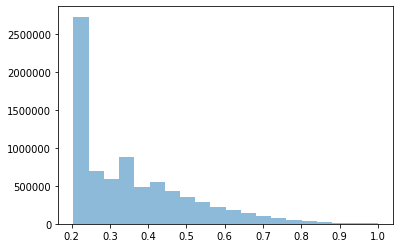

In [74]:
# plt.hist(df_score_1120.final_affluent_score,bins=20,alpha = 0.5)
# #plt.hist(df_score_previous.final_affluent_score,bins=20,alpha = 0.5)
# plt.hist(wealth_score_ref['Final'].join(pd.DataFrame(df_score_1120['customer_id']),on='customer_id',how='inner').final_affluent_score,bins=20,alpha = 0.5)

In [ ]:
# Plot Score Distribution
sns.distplot(df_score_1120.final_affluent_score)
#sns.distplot(df_score_previous.final_affluent_score)
sns.distplot(wealth_score_ref.final_affluent_score)

In [82]:
with open('wealth_score_ref_Final_2_segments.pickle', 'wb') as f:
    pickle.dump(wealth_score_ref,f)
for seg in features_used.keys():
    wealth_score_ref[seg].to_csv('wealth_score_%s_Final_2_segments.csv' % seg,index=False)

In [83]:
for scoring_model_column in list(['wealth_lr']): #,'Wealth_LGB','Wealth_XGB','Wealth_RF'
    for seg in list(wealth_score_ref['Final'].gcs_flag.unique()):

        check = wealth_score_ref['Final'].copy()
        check = check.loc[(check.gcs_flag == seg),['customer_id',scoring_model_column,'affluent_flag']].reset_index(drop=True)

        check[scoring_model_column+'_bin']= pd.qcut(check[scoring_model_column],q = 10, labels = False)
       
        n_affluent_flag_0 = check[check.affluent_flag == 0].customer_id.nunique()
        n_affluent_flag_1 = check[check.affluent_flag == 1].customer_id.nunique()
        
        ks_table_prep = check[[scoring_model_column+'_bin','affluent_flag','customer_id']]
        ks_table_cnt = ks_table_prep.groupby([scoring_model_column+'_bin','affluent_flag']).nunique().customer_id.reset_index()
        ks_table_pivot = ks_table_cnt.pivot(index = scoring_model_column+'_bin',columns = 'affluent_flag',values = 'customer_id').reset_index()
        ks_table = ks_table_pivot.rename({0:'affluent_flag_0',1:'affluent_flag_1'},axis=1)
        grand_total = pd.Series(['Total',n_affluent_flag_0,n_affluent_flag_1],index=ks_table.columns)
        ks_table = ks_table.append(grand_total,ignore_index=True)
        print('GCS_FLAG = %f, Model = %s' %(seg,scoring_model_column))
        print(ks_table)

GCS_FLAG = 1.000000, Model = wealth_lr
affluent_flag wealth_lr_bin  affluent_flag_0  affluent_flag_1
0                         0            19459             2773
1                         1            18593             3638
2                         2            17947             4284
3                         3            17342             4889
4                         4            16678             5553
5                         5            16102             6129
6                         6            15427             6804
7                         7            14443             7788
8                         8            13313             8918
9                         9            10565            11667
10                    Total           159869            62443
GCS_FLAG = 0.000000, Model = wealth_lr
affluent_flag wealth_lr_bin  affluent_flag_0  affluent_flag_1
0                         0           110043             5308
1                         1           106980          